In [1]:
import os
import sys
import pandas as pd
import numpy as np
from scipy.stats import probplot, moment
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import joblib # for save model

In [2]:
import statsmodels.tsa.api as tsa                                      #time_series_models
import statsmodels.api as sm  
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf,acf,plot_pacf,pacf  #plots for autocorrelation and Partial autocorrelation function
from statsmodels.tsa.stattools import acf, q_stat, adfuller   #cross_sectional_models
from arch import arch_model
from arch.univariate import ConstantMean, GARCH, Normal
from scipy import stats
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [3]:
# call data
df = joblib.load("D:/BOOTCAMP/project/Project Pribadi/Udemy - Time Series Analysis in Python/data/data feature/df_time.csv")

### Step make forecasting 

- Check pattern of data return (problab, AR (autocorrelation), and interpretation lineplot)
- Check volality daily, montly, and annual
- Check trend of period
- Check distribution normal and skew from model garch
- Evalution model with likelihood from dist skew and normal (use dist skew if we want forecasting finance and normal if not), in this case we want use dist normal because we want know about forcasting avg price avocado
- Backtest (see MAE and MSE) we can know the model is good or bad from valuse backtest
- Ploting data actual and data result of model
- Forecasting >> see forcasting simulation and bootsrap and then see variance (choose low variance) per period

In [4]:
def correlogram(x, lags, title):
    """
    This function for plotting lineplot,
    ACF, PACF, and problab for interpretation volatility
    """
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14, 8))
    x.plot(ax=axes[0][0],grid= True, color='red')
    q_p = np.max(q_stat(acf(x,lags), len(x))[1])
    stats= f'ADF:{adfuller(x)[1]:.2f},\nQ-Stat:{q_p:.2f}'
    axes[0][0].text(x=.03, y=.85,s=stats, transform=axes[0][0].transAxes)
    
    #probability plot 
    probplot(x, plot=axes[0][1])
    mean, variance, skewness, kurtosis = moment(x, moment=[1, 2, 3, 4])
    stats1 = f'Mean: {mean:.2f}\nSD: {np.sqrt(variance):.2f}\nSkew: {skewness:.2f}\nKurtosis:{kurtosis:.2f}'
    axes[0][1].text(x=.02, y=.75,s=stats1, transform=axes[0][1].transAxes)
    
    #ACF and PACF plots
    plot_acf(x, lags=lags, zero=False, ax=axes[1][0],alpha=0.05,)
    plot_pacf(x, lags=lags, zero=False, ax=axes[1][1])
    axes[1][0].set_xlabel('Lag')
    axes[1][1].set_xlabel('Lag')
    fig.suptitle(title, fontsize=20)
    fig.tight_layout()
    fig.subplots_adjust(top=.9)

C:\Users\HP Notebook\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


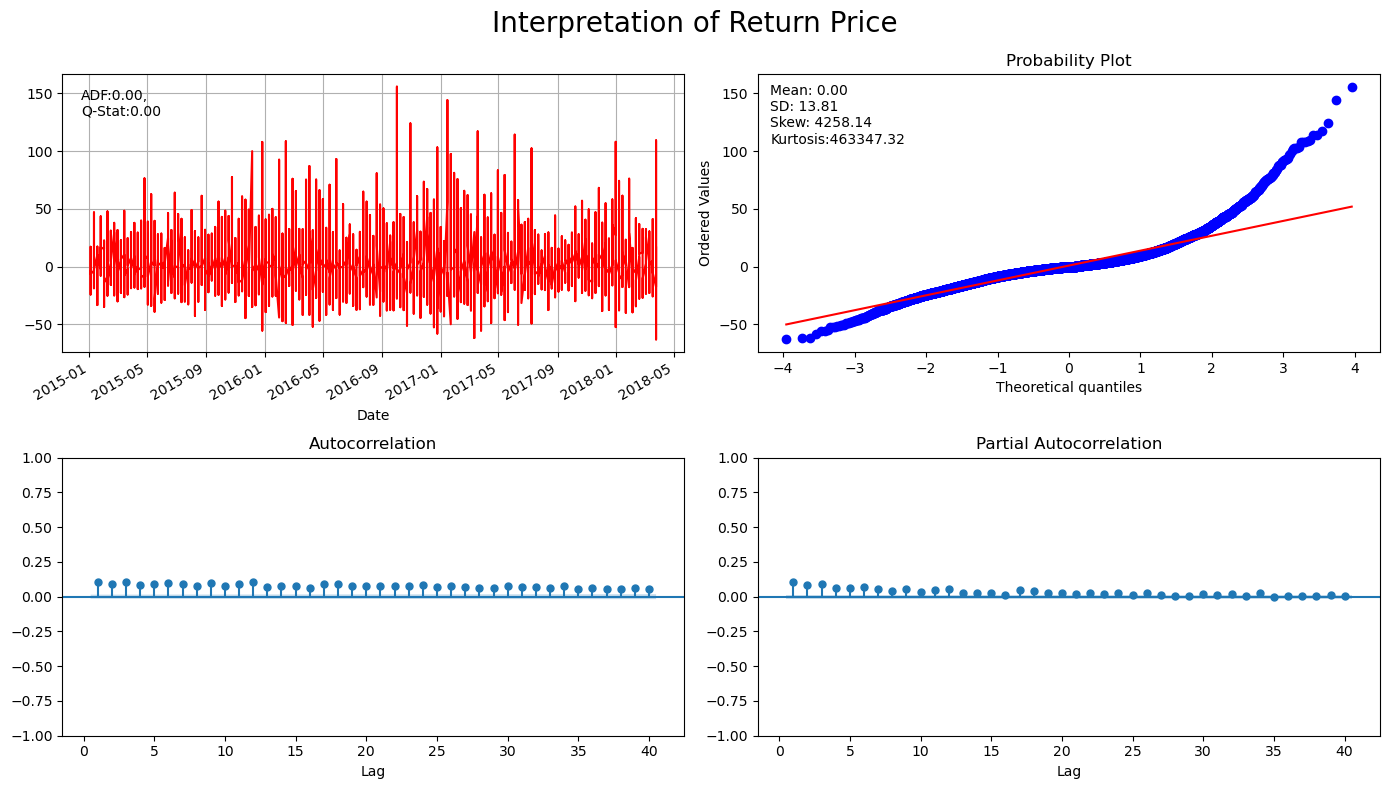

In [5]:
# visualization
correlogram(df.ret_price, lags=40, title = 'Interpretation of Return Price')

From interpretation before, return price the result is not stationary and not normal distribution.

Firstly, we compute the daily volatility as the standard deviation of price returns. Then convert the daily volatility to monthly and annual volatility.

In [6]:
# Calculate daily std of returns
std_daily = df['ret_price'].std()
print(f'Daily volatility: {round(std_daily,2)}%')

# Convert daily volatility to monthly volatility
std_monthly = np.sqrt(21) * std_daily
print(f'\nMonthly volatility: {round(std_monthly,2)}%')

# Convert daily volatility to annaul volatility
std_annual = np.sqrt(252) * std_daily
print(f'\nAnnual volatility: {round(std_annual,2)}%')

Daily volatility: 13.81%

Monthly volatility: 63.27%

Annual volatility: 219.19%


we get that volatily annual and montly from return avg price, it is possible that the asset or financial instrument will experience a larger price movement in a shorter period of time. This means that the investment risk will be higher because sharp and fast price changes can cause significant losses or profits in a short time

# 1. GARCH  Model

### Volatility Trends for Each Period

In [7]:
# fit model ARCH return price
model_garch_pre = arch_model(df.ret_price, mean = "Constant",  vol = "GARCH", p = 1, q = 1, dist = 'normal')
results_garch_pre = model_garch_pre.fit(update_freq = 5)

Iteration:      5,   Func. Count:     32,   Neg. LLF: 72551.44853361236
Iteration:     10,   Func. Count:     62,   Neg. LLF: 72402.97514179928
Optimization terminated successfully    (Exit mode 0)
            Current function value: 72392.80814185961
            Iterations: 14
            Function evaluations: 85
            Gradient evaluations: 14


In [8]:
results_garch_pre.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:              ret_price   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -72392.8
Distribution:                  Normal   AIC:                           144794.
Method:            Maximum Likelihood   BIC:                           144825.
                                        No. Observations:                18249
Date:                Sun, Apr 23 2023   Df Residuals:                    18248
Time:                        18:07:07   Df Model:                            1
                                Mean Model                                
==========================================================================
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu             0.2397      0.103      2.325  2.006e-02 [3.765e-02,  0.442]
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega          1.6526      0.461      3.586  3.354e-04     [  0.749,  2.556]
alpha[1]       0.0342  5.326e-03      6.424  1.324e-10 [2.378e-02,4.466e-02]
beta[1]        0.9579  6.680e-03    143.411      0.000     [  0.945,  0.971]
============================================================================

Covariance estimator: robust
"""

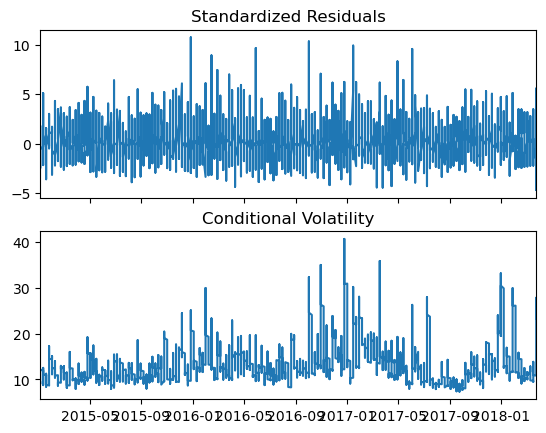

In [9]:
# Plot fitted results
results_garch_pre.plot()
plt.show()

### Distribution Assumtion

GARCH models make distribution assumptions about the residuals and the mean return. Financial time series data often does not follow a normal distribution. In financial time series it is much more likely to observe extreme positive and negative (skew) values that are far away from the mean

C:\Users\HP Notebook\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


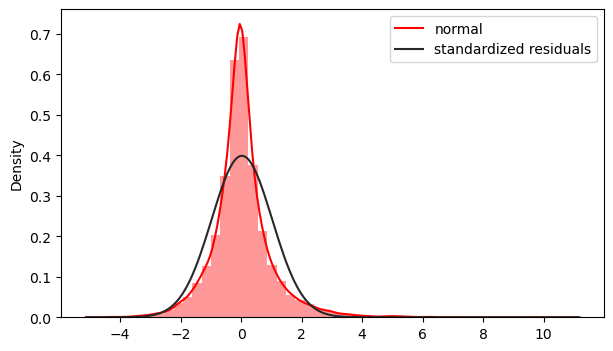

In [10]:
# Obtain model estimated residuals and volatility
gm_resid = results_garch_pre.resid
gm_std = results_garch_pre.conditional_volatility

# Calculate the standardized residuals
gm_std_resid = gm_resid /gm_std

# Plot the histogram of the standardized residuals
plt.figure(figsize=(7,4))
sns.distplot(gm_std_resid, norm_hist=True, fit=stats.norm, bins=50, color='r')
plt.legend(('normal', 'standardized residuals'))
plt.show()

### Skew Assumtion t-distribution

In [11]:
# Specify GARCH model assumptions
skewt_gm = arch_model(df['ret_price'], p = 1, q = 1, mean = 'constant', vol = 'GARCH', dist = 'skewt')

# Fit the model
skewt_result = skewt_gm.fit(disp = 'off')

# Get model estimated volatility
skewt_vol = skewt_result.conditional_volatility

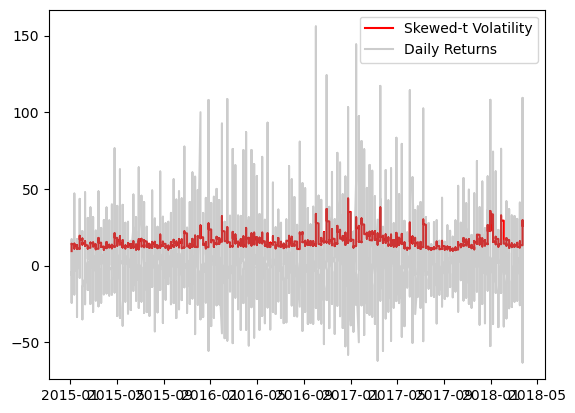

In [12]:
# Plot model fitting results
plt.plot(skewt_vol, color = 'red', label = 'Skewed-t Volatility')
plt.plot(df['ret_price'], color = 'grey', 
         label = 'Daily Returns', alpha = 0.4)
plt.legend(loc = 'upper right')
plt.show()

Result of skew data is left skew or skew negative

# Evalutaion Model GARCH

In [13]:
# Print the log-likelihodd of normal GARCH
print('Log-likelihood of normal GARCH :', results_garch_pre.loglikelihood)
# Print the log-likelihodd of skewt GARCH
print('Log-likelihood of skewt GARCH :', skewt_result.loglikelihood)

Log-likelihood of normal GARCH : -72392.80814185961
Log-likelihood of skewt GARCH : -69882.82423634421


In [14]:
def evaluate(observation, forecast): 
    """
    This function for check backtest
    MAE and MSE
    """
    # Call sklearn function to calculate MAE
    mae = mean_absolute_error(observation, forecast)
    print(f'Mean Absolute Error (MAE): {round(mae,3)}')
    # Call sklearn function to calculate MSE
    mse = mean_squared_error(observation, forecast)
    print(f'Mean Squared Error (MSE): {round(mse,3)}')
    return mae, mse

# Backtest model with MAE, MSE
evaluate(df['ret_price'].sub(df['ret_price'].mean()).pow(2), gm_std**2)

Mean Absolute Error (MAE): 241.079
Mean Squared Error (MSE): 411209.703


(241.0789356368266, 411209.70339896285)

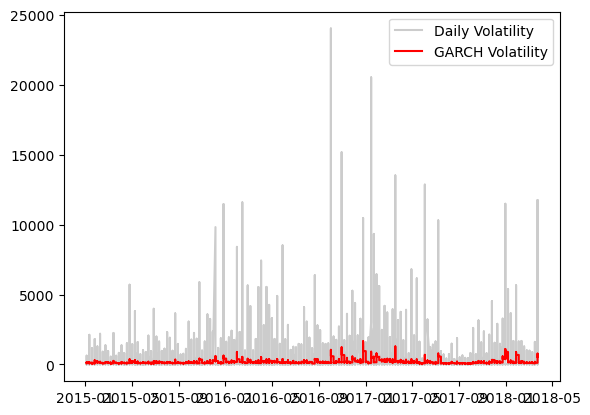

In [15]:
# Plot the actual return_price volatility
plt.plot(df['ret_price'].sub(df['ret_price'].mean()).pow(2), 
         color = 'grey', alpha = 0.4, label = 'Daily Volatility')

# Plot model Garch estimated volatility
plt.plot(gm_std**2, color = 'red', label = 'GARCH Volatility')

plt.legend(loc = 'upper right')
plt.show()

the model so bad, because actual and model very different

# Forecasting

In [30]:
# Make 5-period ahead forecast
gm_forecast = results_garch_pre.forecast(horizon = 5, align = 'target')

# Print the forecast variance
print(gm_forecast.variance[-1:])

                   h.1       h.2         h.3         h.4         h.5
Date                                                                
2018-03-25  528.628197  526.1213  523.634129  521.166527  518.718342


C:\Users\HP Notebook\anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


Forecasting Simulation Method and Bootstrap!

In [17]:
# The paths for the final observation
sim_forecasts = results_garch_pre.forecast(horizon=5, method='simulation')
sim_paths = sim_forecasts.simulations.residual_variances[-1].T
sim = sim_forecasts.simulations

bs_forecasts = results_garch_pre.forecast(horizon=5, method='bootstrap')
bs_paths = bs_forecasts.simulations.residual_variances[-1].T
bs = bs_forecasts.simulations

C:\Users\HP Notebook\anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\HP Notebook\anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


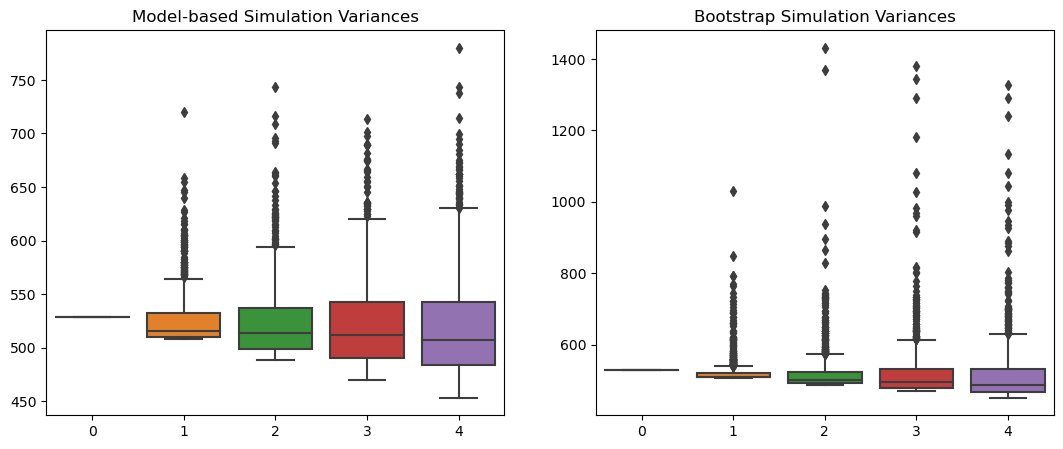

In [18]:
# Plot Simulation Variances
fig, axes = plt.subplots(1, 2, figsize=(13,5))

sns.boxplot(data=sim.variances[-1], ax=axes[0])
sns.boxplot(data=bs.variances[-1], ax=axes[1])

axes[0].set_title('Model-based Simulation Variances')
axes[1].set_title('Bootstrap Simulation Variances')

plt.show()

From forecasting between simultaion and bootsrap, we get best forecasting is simulation, because variance of this forecasting lower than bootsrap. We choose model simulation (see image in below)

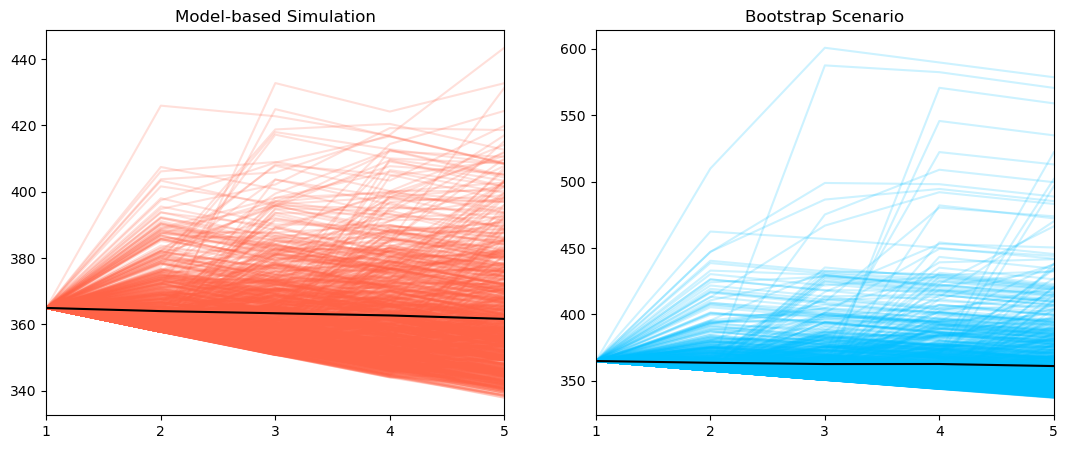

In [19]:
fig, axes = plt.subplots(1, 2, figsize=(13,5))

x = np.arange(1, 6)

# Plot the paths and the mean, set the axis to have the same limit
axes[0].plot(x, np.sqrt(252 * sim_paths), color='tomato', alpha=0.2)
axes[0].plot(x, np.sqrt(252 * sim_forecasts.residual_variance.iloc[-1]),
    color='k', alpha=1)

axes[0].set_title('Model-based Simulation')
axes[0].set_xticks(np.arange(1, 6))
axes[0].set_xlim(1, 5)

axes[1].plot(x, np.sqrt(252 * bs_paths), color='deepskyblue', alpha=0.2)
axes[1].plot(x,np.sqrt(252 * bs_forecasts.residual_variance.iloc[-1]),
    color='k', alpha=1)

axes[1].set_xticks(np.arange(1, 6))
axes[1].set_xlim(1, 5)

axes[1].set_title('Bootstrap Scenario')
plt.show()

# 2. EGARCH Model

### Make comperation from GARCH and EGARCH model with actual data 

In [20]:
# Specify GJR-GARCH model assumptions
gjr_gm = arch_model(df.ret_price, p = 1, q = 1, o = 1, vol = 'GARCH', dist = 't')

# Fit the model
gjrgm_result = gjr_gm.fit(disp = 'off')

# Print model fitting summary
print(gjrgm_result.summary())

                      Constant Mean - GJR-GARCH Model Results                       
Dep. Variable:                    ret_price   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                        GJR-GARCH   Log-Likelihood:               -69902.8
Distribution:      Standardized Student's t   AIC:                           139818.
Method:                  Maximum Likelihood   BIC:                           139864.
                                              No. Observations:                18249
Date:                      Sun, Apr 23 2023   Df Residuals:                    18248
Time:                              18:07:21   Df Model:                            1
                               Mean Model                               
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu            -0

In [21]:
# Specify EGARCH model assumptions
egarch_gm = arch_model(df.ret_price, p = 1, q = 1, o = 1, vol = 'EGARCH', dist = 't')

# Fit the model
egarch_result = egarch_gm.fit(disp = 'off')

# Print model fitting summary
print(egarch_result.summary())

                        Constant Mean - EGARCH Model Results                        
Dep. Variable:                    ret_price   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                           EGARCH   Log-Likelihood:               -69795.0
Distribution:      Standardized Student's t   AIC:                           139602.
Method:                  Maximum Likelihood   BIC:                           139649.
                                              No. Observations:                18249
Date:                      Sun, Apr 23 2023   Df Residuals:                    18248
Time:                              18:07:21   Df Model:                            1
                               Mean Model                               
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu            -0

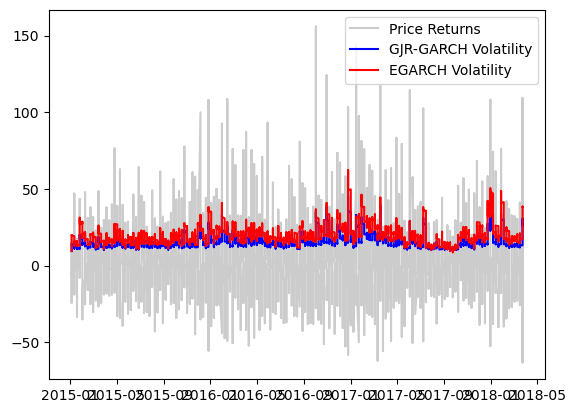

In [22]:
gjrgm_vol = gjrgm_result.conditional_volatility
egarch_vol = egarch_result.conditional_volatility

# Plot the actual ret_price returns
plt.plot(df.ret_price, color = 'grey', alpha = 0.4, label = 'Price Returns')

# Plot GJR-GARCH estimated volatility
plt.plot(gjrgm_vol, color = 'blue', label = 'GJR-GARCH Volatility')

# Plot EGARCH  estimated volatility
plt.plot(egarch_vol, color = 'red', label = 'EGARCH Volatility')

plt.legend(loc = 'upper right')
plt.show()

In [23]:
# Print each models BIC
print(f'GJR-GARCH BIC: {gjrgm_result.bic}')
print(f'\nEGARCH BIC: {egarch_result.bic}')

GJR-GARCH BIC: 139864.38974199948

EGARCH BIC: 139648.8445822153


The comperation between model GARCH and EGARCH not far and this is good comperation

# Evalutaion Model EGARCH

In [24]:
# Print the log-likelihodd of normal GARCH
print('Log-likelihood of normal GARCH :', egarch_result.loglikelihood)

Log-likelihood of normal GARCH : -69794.98669441868


In [25]:
def evaluate(observation, forecast): 
    """
    This function for check backtest
    MAE and MSE
    """
    # Call sklearn function to calculate MAE
    mae = mean_absolute_error(observation, forecast)
    print(f'Mean Absolute Error (MAE): {round(mae,3)}')
    # Call sklearn function to calculate MSE
    mse = mean_squared_error(observation, forecast)
    print(f'Mean Squared Error (MSE): {round(mse,3)}')
    return mae, mse

# Backtest model with MAE, MSE
evaluate(df['ret_price'].sub(df['ret_price'].mean()).pow(2), egarch_vol**2)

Mean Absolute Error (MAE): 414.714
Mean Squared Error (MSE): 512053.88


(414.7136448242806, 512053.8801483366)

# Forecasting

In [26]:
# Make 5-period ahead forecast
gm_forecast_2 = egarch_result.forecast(horizon = 1)

# Print the forecast variance
print(gm_forecast_2.variance[-1:])

                    h.1
Date                   
2018-03-25  1454.565177


C:\Users\HP Notebook\anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


In [27]:
# The paths for the final observation
sim_forecasts_2 = egarch_result.forecast(horizon=5, method='simulation')
sim_paths_ = sim_forecasts_2.simulations.residual_variances[-1].T
sim_2 = sim_forecasts.simulations

bs_forecasts_2 = egarch_result.forecast(horizon=5, method='bootstrap')
bs_paths_2 = bs_forecasts_2.simulations.residual_variances[-1].T
bs_2 = bs_forecasts.simulations

C:\Users\HP Notebook\anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\HP Notebook\anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


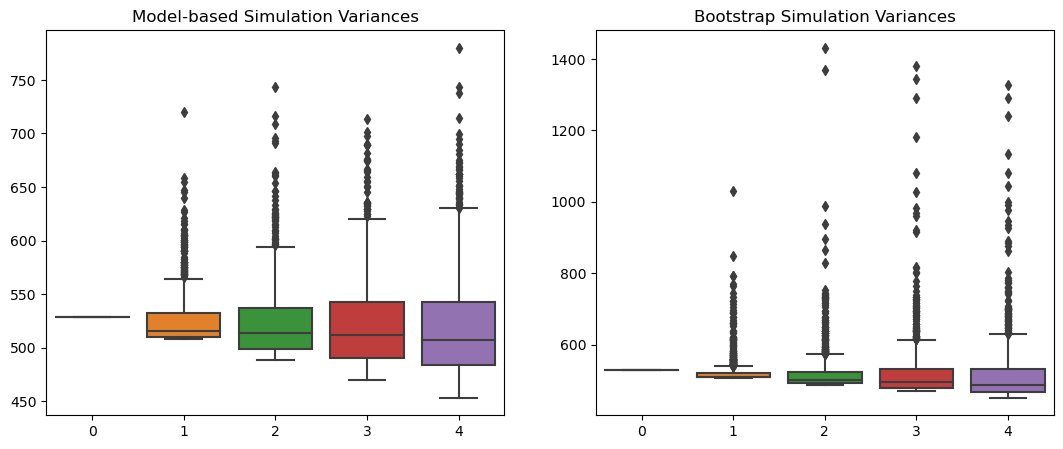

In [28]:
# Plot Simulation Variances
fig, axes = plt.subplots(1, 2, figsize=(13,5))

sns.boxplot(data=sim_2.variances[-1], ax=axes[0])
sns.boxplot(data=bs_2.variances[-1], ax=axes[1])

axes[0].set_title('Model-based Simulation Variances')
axes[1].set_title('Bootstrap Simulation Variances')

plt.show()

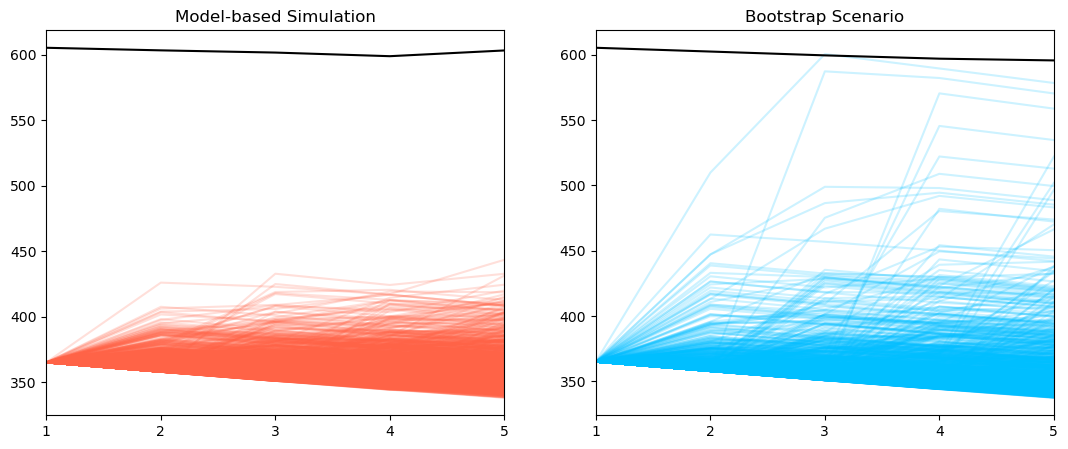

In [29]:
fig, axes = plt.subplots(1, 2, figsize=(13,5))

x = np.arange(1, 6)

# Plot the paths and the mean, set the axis to have the same limit
axes[0].plot(x, np.sqrt(252 * sim_paths), color='tomato', alpha=0.2)
axes[0].plot(x, np.sqrt(252 * sim_forecasts_2.residual_variance.iloc[-1]),
    color='k', alpha=1)

axes[0].set_title('Model-based Simulation')
axes[0].set_xticks(np.arange(1, 6))
axes[0].set_xlim(1, 5)

axes[1].plot(x, np.sqrt(252 * bs_paths), color='deepskyblue', alpha=0.2)
axes[1].plot(x,np.sqrt(252 * bs_forecasts_2.residual_variance.iloc[-1]),
    color='k', alpha=1)

axes[1].set_xticks(np.arange(1, 6))
axes[1].set_xlim(1, 5)

axes[1].set_title('Bootstrap Scenario')
plt.show()

# Result of Volatility 

comperation of best model is GARCH because the model have variance and MAE or MSE lower than model EGARCH, and we see from plot forecasting best model GARCH simulation is the best compared to bootsrap.

- Forecast increased per period but period 2 to 3 have highest spike 